# 1

=== ANÁLISIS DE VARIABLES CATEGÓRICAS ===

Variables categóricas identificadas: ['PLAN', 'SUBACCESO', 'APERTURA', 'GENERO', 'MUNICIPIO_NACIMIENTO', 'NACIONALIDAD', 'VICTIMAS_DEL_CONFLICTO', 'DISCAPACIDAD', 'CARACTER_COLEGIO', 'MUNICIPIO_RESIDENCIA_FAM', 'NODO_INICIO']

--- PLAN ---
Valores únicos: 6
Valores: ['GEOGRAFÍA' 'BIOLOGÍA' 'GESTIÓN CULTURAL Y COMUNICATIVA'
 'INGENIERÍA MECATRÓNICA' 'INGENIERÍA BIOLÓGICA' 'ESTADÍSTICA']
Distribución:
INGENIERÍA MECATRÓNICA             253
BIOLOGÍA                           242
INGENIERÍA BIOLÓGICA               223
GEOGRAFÍA                          197
GESTIÓN CULTURAL Y COMUNICATIVA    193
ESTADÍSTICA                        175
Name: PLAN, dtype: int64

--- SUBACCESO ---
Valores únicos: 5
Valores: ['PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAMAS DE PREGRADO SEDE LA PAZ'
 'REGULAR DE PREGRADO' 'PAES - INDÍGENA'
 'VÍCTIMAS DEL CONFLICTO ARMADO EN COLOMBIA'
 'PAES - POBLACION NEGRA, AFROCOLOMBIANA, PALENQUERA Y RAIZAL']
Distribución:
PROGRAMA 

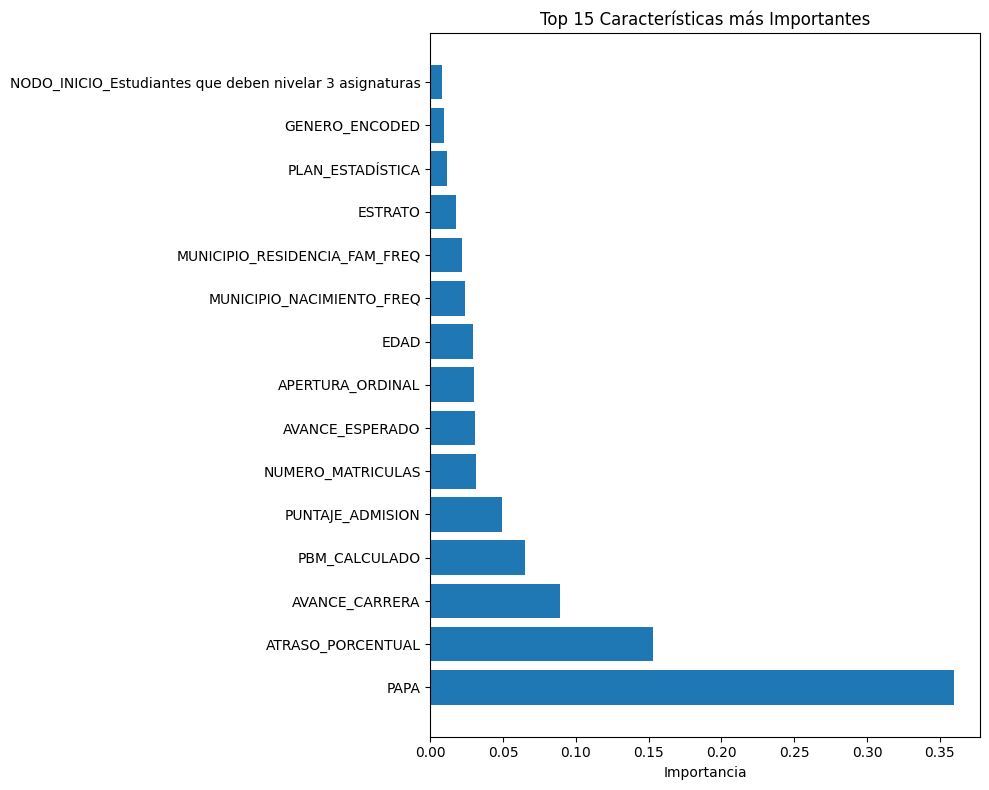


=== CÓDIGO LISTO PARA USAR CON TUS DATOS COMPLETOS ===
Usa la función apply_encodings_to_new_data() para aplicar las mismas codificaciones a tu dataset completo.


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
df = pd.read_excel('df_objetivo/df_objetivo_imputado.xlsx')

print("=== ANÁLISIS DE VARIABLES CATEGÓRICAS ===\n")

# Identificar variables categóricas
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()
print(f"Variables categóricas identificadas: {categorical_vars}\n")

# Análisis detallado de cada variable categórica
for var in categorical_vars:
    print(f"--- {var} ---")
    print(f"Valores únicos: {df[var].nunique()}")
    print(f"Valores: {df[var].unique()}")
    print(f"Distribución:")
    print(df[var].value_counts())
    print()

# Función para crear codificaciones
def create_encodings(df):
    """
    Crea diferentes tipos de codificaciones para las variables categóricas
    """
    df_encoded = df.copy()
    
    # 1. PLAN - One-Hot Encoding (pocas categorías, no hay orden)
    plan_dummies = pd.get_dummies(df['PLAN'], prefix='PLAN')
    df_encoded = pd.concat([df_encoded, plan_dummies], axis=1)
    
    # 2. SUBACCESO - One-Hot Encoding (pocas categorías, no hay orden)
    subacceso_dummies = pd.get_dummies(df['SUBACCESO'], prefix='SUBACCESO')
    df_encoded = pd.concat([df_encoded, subacceso_dummies], axis=1)
    
    # 3. APERTURA - Codificación ordinal (hay orden temporal)
    apertura_mapping = {
        '2019-2S': 1, '2020-1S': 2, '2020-2S': 3, '2021-1S': 4, 
        '2021-2S': 5, '2022-1S': 6, '2022-2S': 7, '2023-1S': 8, 
        '2023-2S': 9, '2024-1S': 10, '2024-2S': 11
    }
    df_encoded['APERTURA_ORDINAL'] = df['APERTURA'].map(apertura_mapping)
    
    # 4. GENERO - Label Encoding (binaria)
    le_genero = LabelEncoder()
    df_encoded['GENERO_ENCODED'] = le_genero.fit_transform(df['GENERO'])
    
    # 5. MUNICIPIO_NACIMIENTO - Frequency Encoding (muchas categorías)
    freq_mun_nac = df['MUNICIPIO_NACIMIENTO'].value_counts().to_dict()
    df_encoded['MUNICIPIO_NACIMIENTO_FREQ'] = df['MUNICIPIO_NACIMIENTO'].map(freq_mun_nac)
    
    # 6. NACIONALIDAD - Label Encoding (pocas categorías)
    le_nacionalidad = LabelEncoder()
    df_encoded['NACIONALIDAD_ENCODED'] = le_nacionalidad.fit_transform(df['NACIONALIDAD'])
    
    # 7. VICTIMAS_DEL_CONFLICTO - Label Encoding (binaria)
    le_victimas = LabelEncoder()
    df_encoded['VICTIMAS_ENCODED'] = le_victimas.fit_transform(df['VICTIMAS_DEL_CONFLICTO'])
    
    # 8. DISCAPACIDAD - Label Encoding (binaria)
    le_discapacidad = LabelEncoder()
    df_encoded['DISCAPACIDAD_ENCODED'] = le_discapacidad.fit_transform(df['DISCAPACIDAD'])
    
    # 9. CARACTER_COLEGIO - Label Encoding (binaria)
    le_caracter = LabelEncoder()
    df_encoded['CARACTER_COLEGIO_ENCODED'] = le_caracter.fit_transform(df['CARACTER_COLEGIO'])
    
    # 10. MUNICIPIO_RESIDENCIA_FAM - Frequency Encoding (muchas categorías)
    freq_mun_res = df['MUNICIPIO_RESIDENCIA_FAM'].value_counts().to_dict()
    df_encoded['MUNICIPIO_RESIDENCIA_FAM_FREQ'] = df['MUNICIPIO_RESIDENCIA_FAM'].map(freq_mun_res)
    
    # 11. NODO_INICIO - One-Hot Encoding (pocas categorías)
    nodo_dummies = pd.get_dummies(df['NODO_INICIO'], prefix='NODO_INICIO')
    df_encoded = pd.concat([df_encoded, nodo_dummies], axis=1)
    
    return df_encoded, {
        'genero': le_genero,
        'nacionalidad': le_nacionalidad,
        'victimas': le_victimas,
        'discapacidad': le_discapacidad,
        'caracter_colegio': le_caracter,
        'apertura_mapping': apertura_mapping,
        'freq_mun_nac': freq_mun_nac,
        'freq_mun_res': freq_mun_res
    }

# Aplicar codificaciones
df_encoded, encoders = create_encodings(df)

# Seleccionar características codificadas para el modelo
feature_columns = [
    # Variables numéricas originales
    'AVANCE_CARRERA', 'EDAD', 'NUMERO_MATRICULAS', 'PAPA', 'PBM_CALCULADO', 
    'ESTRATO', 'PUNTAJE_ADMISION', 'AVANCE_ESPERADO', 'ATRASO_PORCENTUAL',
    
    # Variables categóricas codificadas
    'APERTURA_ORDINAL', 'GENERO_ENCODED', 'NACIONALIDAD_ENCODED', 
    'VICTIMAS_ENCODED', 'DISCAPACIDAD_ENCODED', 'CARACTER_COLEGIO_ENCODED',
    'MUNICIPIO_NACIMIENTO_FREQ', 'MUNICIPIO_RESIDENCIA_FAM_FREQ'
]

# Añadir columnas dummy
plan_cols = [col for col in df_encoded.columns if col.startswith('PLAN_')]
subacceso_cols = [col for col in df_encoded.columns if col.startswith('SUBACCESO_')]
nodo_cols = [col for col in df_encoded.columns if col.startswith('NODO_INICIO_')]

feature_columns.extend(plan_cols)
feature_columns.extend(subacceso_cols)
feature_columns.extend(nodo_cols)

# Preparar datos para el modelo
X = df_encoded[feature_columns]
y = df_encoded['RIESGO_DESERCION']

print("=== RESUMEN DE CODIFICACIONES APLICADAS ===\n")
print("1. PLAN: One-Hot Encoding (5 categorías)")
print("2. SUBACCESO: One-Hot Encoding (4 categorías)")
print("3. APERTURA: Codificación Ordinal (orden temporal)")
print("4. GENERO: Label Encoding (binaria)")
print("5. MUNICIPIO_NACIMIENTO: Frequency Encoding (muchas categorías)")
print("6. NACIONALIDAD: Label Encoding (pocas categorías)")
print("7. VICTIMAS_DEL_CONFLICTO: Label Encoding (binaria)")
print("8. DISCAPACIDAD: Label Encoding (binaria)")
print("9. CARACTER_COLEGIO: Label Encoding (binaria)")
print("10. MUNICIPIO_RESIDENCIA_FAM: Frequency Encoding (muchas categorías)")
print("11. NODO_INICIO: One-Hot Encoding (pocas categorías)")

print(f"\nDimensiones finales del dataset: {X.shape}")
print(f"Características utilizadas: {len(feature_columns)}")

# Entrenar modelo de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest para evaluar importancia de características
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)

print("\n=== EVALUACIÓN DEL MODELO ===")
print(f"Accuracy: {rf.score(X_test, y_test):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Importancia de características
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== TOP 15 CARACTERÍSTICAS MÁS IMPORTANTES ===")
print(feature_importance.head(15))

# Visualización de importancia
plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance.head(15)['importance'])
plt.yticks(range(15), feature_importance.head(15)['feature'])
plt.xlabel('Importancia')
plt.title('Top 15 Características más Importantes')
plt.tight_layout()
plt.show()

# Función para aplicar las mismas codificaciones a nuevos datos
def apply_encodings_to_new_data(new_df, encoders):
    """
    Aplica las mismas codificaciones a un nuevo dataset
    """
    new_df_encoded = new_df.copy()
    
    # Aplicar codificaciones
    new_df_encoded['APERTURA_ORDINAL'] = new_df['APERTURA'].map(encoders['apertura_mapping'])
    new_df_encoded['GENERO_ENCODED'] = encoders['genero'].transform(new_df['GENERO'])
    new_df_encoded['NACIONALIDAD_ENCODED'] = encoders['nacionalidad'].transform(new_df['NACIONALIDAD'])
    new_df_encoded['VICTIMAS_ENCODED'] = encoders['victimas'].transform(new_df['VICTIMAS_DEL_CONFLICTO'])
    new_df_encoded['DISCAPACIDAD_ENCODED'] = encoders['discapacidad'].transform(new_df['DISCAPACIDAD'])
    new_df_encoded['CARACTER_COLEGIO_ENCODED'] = encoders['caracter_colegio'].transform(new_df['CARACTER_COLEGIO'])
    new_df_encoded['MUNICIPIO_NACIMIENTO_FREQ'] = new_df['MUNICIPIO_NACIMIENTO'].map(encoders['freq_mun_nac'])
    new_df_encoded['MUNICIPIO_RESIDENCIA_FAM_FREQ'] = new_df['MUNICIPIO_RESIDENCIA_FAM'].map(encoders['freq_mun_res'])
    
    # One-hot encoding
    plan_dummies = pd.get_dummies(new_df['PLAN'], prefix='PLAN')
    subacceso_dummies = pd.get_dummies(new_df['SUBACCESO'], prefix='SUBACCESO')
    nodo_dummies = pd.get_dummies(new_df['NODO_INICIO'], prefix='NODO_INICIO')
    
    new_df_encoded = pd.concat([new_df_encoded, plan_dummies, subacceso_dummies, nodo_dummies], axis=1)
    
    return new_df_encoded

print("\n=== CÓDIGO LISTO PARA USAR CON TUS DATOS COMPLETOS ===")
print("Usa la función apply_encodings_to_new_data() para aplicar las mismas codificaciones a tu dataset completo.")

# 2

In [19]:
import pandas as pd
import numpy as np
from collections import Counter

# Cargar el dataset
df = pd.read_excel('df_objetivo/df_objetivo_imputado.xlsx')

print("="*80)
print("ANÁLISIS DE VARIABLES CATEGÓRICAS PARA CODIFICACIÓN")
print("="*80)

# Identificar variables categóricas (excluyendo la variable objetivo)
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()
if 'RIESGO_DESERCION' in categorical_vars:
    categorical_vars.remove('RIESGO_DESERCION')

print(f"\nVariables categóricas identificadas: {len(categorical_vars)}")
print(f"Variables: {categorical_vars}")

def analyze_categorical_variable(df, var_name):
    """Analiza una variable categórica y sugiere el tipo de codificación"""
    print(f"\n{'='*60}")
    print(f"VARIABLE: {var_name}")
    print(f"{'='*60}")
    
    # Estadísticas básicas
    unique_values = df[var_name].nunique()
    total_observations = len(df)
    value_counts = df[var_name].value_counts()
    
    print(f"Número de categorías únicas: {unique_values}")
    print(f"Total de observaciones: {total_observations}")
    print(f"Ratio categorías/observaciones: {unique_values/total_observations:.3f}")
    
    # Mostrar todas las categorías y sus frecuencias
    print(f"\nDistribución de categorías:")
    for i, (category, count) in enumerate(value_counts.items(), 1):
        percentage = (count/total_observations)*100
        print(f"{i:2d}. {category}: {count} ({percentage:.1f}%)")
    
    # Análisis de distribución
    print(f"\nAnálisis de distribución:")
    print(f"Categoría más frecuente: {value_counts.index[0]} ({value_counts.iloc[0]} obs, {(value_counts.iloc[0]/total_observations)*100:.1f}%)")
    print(f"Categoría menos frecuente: {value_counts.index[-1]} ({value_counts.iloc[-1]} obs, {(value_counts.iloc[-1]/total_observations)*100:.1f}%)")
    
    # Verificar si hay orden natural
    has_natural_order = False
    ordinal_hint = ""
    
    if var_name in ['ESTRATO']:
        has_natural_order = True
        ordinal_hint = "Variable con orden natural (socioeconómico)"
    elif var_name in ['EDAD']:
        has_natural_order = True
        ordinal_hint = "Variable numérica que podría agruparse ordinalmente"
    
    # Análisis de cardinalidad para sugerir codificación
    print(f"\nRecomendación de codificación:")
    
    if unique_values <= 5 and not has_natural_order:
        print("✓ ONE-HOT ENCODING")
        print("  Razón: Pocas categorías, no hay orden natural")
        recommendation = "One-Hot Encoding"
    elif unique_values <= 5 and has_natural_order:
        print("✓ ORDINAL ENCODING")
        print(f"  Razón: {ordinal_hint}")
        recommendation = "Ordinal Encoding"
    elif unique_values > 5 and unique_values <= 10:
        if has_natural_order:
            print("✓ ORDINAL ENCODING")
            print(f"  Razón: {ordinal_hint}")
            recommendation = "Ordinal Encoding"
        else:
            print("✓ ONE-HOT ENCODING o TARGET ENCODING")
            print("  Razón: Cardinalidad media, evaluar según contexto")
            recommendation = "One-Hot o Target Encoding"
    elif unique_values > 10:
        if value_counts.iloc[0] / total_observations > 0.5:
            print("✓ TARGET ENCODING o FREQUENCY ENCODING")
            print("  Razón: Alta cardinalidad con categoría dominante")
            recommendation = "Target o Frequency Encoding"
        else:
            print("✓ TARGET ENCODING")
            print("  Razón: Alta cardinalidad, evitar dimensionalidad")
            recommendation = "Target Encoding"
    
    # Análisis de relación con variable objetivo
    if 'RIESGO_DESERCION' in df.columns:
        print(f"\nRelación con RIESGO_DESERCION:")
        crosstab = pd.crosstab(df[var_name], df['RIESGO_DESERCION'], normalize='index')
        print(crosstab.round(3))
        
        # Calcular diferencias en tasas de deserción
        if 0 in crosstab.columns and 1 in crosstab.columns:
            desertion_rates = crosstab[1]
            max_rate = desertion_rates.max()
            min_rate = desertion_rates.min()
            rate_difference = max_rate - min_rate
            print(f"Diferencia en tasas de deserción: {rate_difference:.3f}")
            
            if rate_difference > 0.2:
                print("⚠️  ALTA VARIABILIDAD - Target Encoding muy recomendado")
    
    return {
        'variable': var_name,
        'unique_categories': unique_values,
        'total_observations': total_observations,
        'most_frequent': value_counts.index[0],
        'most_frequent_count': value_counts.iloc[0],
        'least_frequent': value_counts.index[-1],
        'least_frequent_count': value_counts.iloc[-1],
        'recommended_encoding': recommendation,
        'has_natural_order': has_natural_order
    }

# Analizar cada variable categórica
results = []
for var in categorical_vars:
    result = analyze_categorical_variable(df, var)
    results.append(result)

# Resumen de recomendaciones
print(f"\n{'='*80}")
print("RESUMEN DE RECOMENDACIONES DE CODIFICACIÓN")
print(f"{'='*80}")

recommendations_df = pd.DataFrame(results)
print(recommendations_df[['variable', 'unique_categories', 'recommended_encoding']].to_string(index=False))

print(f"\n{'='*80}")
print("CONSIDERACIONES ADICIONALES")
print(f"{'='*80}")

print("""
1. ONE-HOT ENCODING:
   - Usar para variables nominales con pocas categorías (≤5)
   - Aumenta la dimensionalidad
   - Funciona bien con la mayoría de algoritmos

2. ORDINAL ENCODING:
   - Usar para variables con orden natural
   - Mantiene la información de orden
   - Cuidado con algoritmos que asumen distancias numéricas

3. TARGET ENCODING:
   - Usar para variables de alta cardinalidad
   - Útil cuando hay relación fuerte con la variable objetivo
   - Riesgo de overfitting - usar validación cruzada

4. FREQUENCY ENCODING:
   - Alternativa a target encoding
   - Menos propenso a overfitting
   - Útil para variables con categorías muy desbalanceadas

5. VARIABLES ESPECIALES:
   - MUNICIPIO_*: Considerar agrupamiento geográfico
   - PLAN: Podría requerir análisis semántico
   - NODO_INICIO: Evaluar agrupamiento por tipo de nivelación
""")

# Análisis específico para variables problemáticas
print(f"\n{'='*60}")
print("ANÁLISIS ESPECÍFICO PARA VARIABLES DE ALTA CARDINALIDAD")
print(f"{'='*60}")

high_cardinality_vars = [var for var in categorical_vars if df[var].nunique() > 10]
for var in high_cardinality_vars:
    print(f"\n{var}:")
    print(f"  - Categorías únicas: {df[var].nunique()}")
    print(f"  - Categorías con 1 sola observación: {sum(df[var].value_counts() == 1)}")
    print(f"  - Categoría más frecuente representa: {(df[var].value_counts().iloc[0]/len(df))*100:.1f}% del dataset")

ANÁLISIS DE VARIABLES CATEGÓRICAS PARA CODIFICACIÓN

Variables categóricas identificadas: 11
Variables: ['PLAN', 'SUBACCESO', 'APERTURA', 'GENERO', 'MUNICIPIO_NACIMIENTO', 'NACIONALIDAD', 'VICTIMAS_DEL_CONFLICTO', 'DISCAPACIDAD', 'CARACTER_COLEGIO', 'MUNICIPIO_RESIDENCIA_FAM', 'NODO_INICIO']

VARIABLE: PLAN
Número de categorías únicas: 6
Total de observaciones: 1283
Ratio categorías/observaciones: 0.005

Distribución de categorías:
 1. INGENIERÍA MECATRÓNICA: 253 (19.7%)
 2. BIOLOGÍA: 242 (18.9%)
 3. INGENIERÍA BIOLÓGICA: 223 (17.4%)
 4. GEOGRAFÍA: 197 (15.4%)
 5. GESTIÓN CULTURAL Y COMUNICATIVA: 193 (15.0%)
 6. ESTADÍSTICA: 175 (13.6%)

Análisis de distribución:
Categoría más frecuente: INGENIERÍA MECATRÓNICA (253 obs, 19.7%)
Categoría menos frecuente: ESTADÍSTICA (175 obs, 13.6%)

Recomendación de codificación:
✓ ONE-HOT ENCODING o TARGET ENCODING
  Razón: Cardinalidad media, evaluar según contexto

Relación con RIESGO_DESERCION:
RIESGO_DESERCION                     0      1
PLAN    

# 3 Categóricas

In [22]:
import pandas as pd
import numpy as np

# Cargar el dataset
df = pd.read_excel('df_objetivo/df_objetivo_imputado.xlsx')

# Identificar variables categóricas
categorical_vars = ['PLAN', 'SUBACCESO', 'APERTURA', 'GENERO', 'MUNICIPIO_NACIMIENTO', 
                   'NACIONALIDAD', 'VICTIMAS_DEL_CONFLICTO', 'DISCAPACIDAD', 'CARACTER_COLEGIO',
                   'MUNICIPIO_RESIDENCIA_FAM', 'NODO_INICIO']

# Variable objetivo
target_var = 'RIESGO_DESERCION'

print("ANÁLISIS DE VARIABLES CATEGÓRICAS PARA CODIFICACIÓN")
print("=" * 60)

for var in categorical_vars:
    print(f"\nVARIABLE: {var}")
    print(f"Tipo: {df[var].dtype}")
    
    # Conteo de valores únicos
    unique_count = df[var].nunique()
    print(f"Valores únicos: {unique_count}")
    
    # Distribución de frecuencias
    value_counts = df[var].value_counts()
    print(f"Distribución de frecuencias:")
    for value, count in value_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {value}: {count} ({percentage:.1f}%)")
    
    # Relación con variable objetivo
    if target_var in df.columns:
        crosstab = pd.crosstab(df[var], df[target_var])
        print(f"Relación con {target_var}:")
        for category in crosstab.index:
            total = crosstab.loc[category].sum()
            desercion_rate = (crosstab.loc[category, 1] / total * 100) if 1 in crosstab.columns else 0
            print(f"  {category}: {desercion_rate:.1f}% deserción")
    
    # Características para decisión de codificación
    print(f"Características:")
    print(f"  - Cardinalidad: {'Alta' if unique_count > 10 else 'Media' if unique_count > 5 else 'Baja'}")
    print(f"  - Distribución: {'Balanceada' if value_counts.std() < value_counts.mean() else 'Desbalanceada'}")
    
    # Verificar si hay orden natural
    if var in ['APERTURA']:
        print(f"  - Orden natural: Sí (temporal)")
    elif var in ['ESTRATO']:
        print(f"  - Orden natural: Sí (ordinal)")
    else:
        print(f"  - Orden natural: No")
    
    print("-" * 40)

# Resumen final con recomendaciones
print("\nRESUMEN PARA CODIFICACIÓN:")
print("=" * 60)

# Análisis automático de recomendaciones
for var in categorical_vars:
    unique_count = df[var].nunique()
    value_counts = df[var].value_counts()
    
    print(f"\n{var}:")
    
    if unique_count == 2:
        print("  Recomendación: Label Encoding (binaria)")
    elif unique_count <= 5 and value_counts.std() < value_counts.mean():
        print("  Recomendación: One-Hot Encoding (baja cardinalidad, balanceada)")
    elif unique_count <= 10:
        print("  Recomendación: Target Encoding o One-Hot Encoding")
    else:
        print("  Recomendación: Target Encoding (alta cardinalidad)")
    
    print(f"  Cardinalidad: {unique_count}")
    print(f"  Distribución std/mean: {value_counts.std()/value_counts.mean():.2f}")

print("\nVARIABLES NUMÉRICAS (no requieren codificación):")
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
for var in numeric_vars:
    if var != target_var:
        print(f"  - {var}")

ANÁLISIS DE VARIABLES CATEGÓRICAS PARA CODIFICACIÓN

VARIABLE: PLAN
Tipo: object
Valores únicos: 6
Distribución de frecuencias:
  INGENIERÍA MECATRÓNICA: 253 (19.7%)
  BIOLOGÍA: 242 (18.9%)
  INGENIERÍA BIOLÓGICA: 223 (17.4%)
  GEOGRAFÍA: 197 (15.4%)
  GESTIÓN CULTURAL Y COMUNICATIVA: 193 (15.0%)
  ESTADÍSTICA: 175 (13.6%)
Relación con RIESGO_DESERCION:
  BIOLOGÍA: 13.2% deserción
  ESTADÍSTICA: 27.4% deserción
  GEOGRAFÍA: 11.2% deserción
  GESTIÓN CULTURAL Y COMUNICATIVA: 8.3% deserción
  INGENIERÍA BIOLÓGICA: 15.7% deserción
  INGENIERÍA MECATRÓNICA: 13.8% deserción
Características:
  - Cardinalidad: Media
  - Distribución: Balanceada
  - Orden natural: No
----------------------------------------

VARIABLE: SUBACCESO
Tipo: object
Valores únicos: 5
Distribución de frecuencias:
  PROGRAMA DE ADMISIÓN ESPECIAL PARA LOS PROGRAMAS DE PREGRADO SEDE LA PAZ: 910 (70.9%)
  REGULAR DE PREGRADO: 213 (16.6%)
  VÍCTIMAS DEL CONFLICTO ARMADO EN COLOMBIA: 117 (9.1%)
  PAES - INDÍGENA: 22 (1.7%)
  

# 4 - numéricas

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Cargar el dataset
df = pd.read_excel('df_objetivo/df_objetivo_imputado.xlsx')

# Identificar variables numéricas (excluyendo variable objetivo)
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
target_var = 'RIESGO_DESERCION'
if target_var in numeric_vars:
    numeric_vars.remove(target_var)

print("ANÁLISIS DE VARIABLES NUMÉRICAS PARA ESCALADO")
print("=" * 60)

for var in numeric_vars:
    print(f"\nVARIABLE: {var}")
    
    # Estadísticas básicas
    data = df[var].dropna()
    print(f"Estadísticas básicas:")
    print(f"  Media: {data.mean():.3f}")
    print(f"  Mediana: {data.median():.3f}")
    print(f"  Desviación estándar: {data.std():.3f}")
    print(f"  Mínimo: {data.min():.3f}")
    print(f"  Máximo: {data.max():.3f}")
    print(f"  Rango: {data.max() - data.min():.3f}")
    
    # Percentiles
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    print(f"  Q1: {q25:.3f}")
    print(f"  Q3: {q75:.3f}")
    print(f"  IQR: {iqr:.3f}")
    
    # Análisis de distribución
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    print(f"Distribución:")
    print(f"  Asimetría (skewness): {skewness:.3f}")
    print(f"  Curtosis (kurtosis): {kurtosis:.3f}")
    
    # Clasificación de asimetría
    if abs(skewness) < 0.5:
        skew_type = "Aproximadamente simétrica"
    elif abs(skewness) < 1:
        skew_type = "Moderadamente asimétrica"
    else:
        skew_type = "Altamente asimétrica"
    print(f"  Tipo: {skew_type}")
    
    # Detección de outliers
    outlier_threshold_low = q25 - 1.5 * iqr
    outlier_threshold_high = q75 + 1.5 * iqr
    outliers = data[(data < outlier_threshold_low) | (data > outlier_threshold_high)]
    outlier_percentage = (len(outliers) / len(data)) * 100
    print(f"Outliers:")
    print(f"  Cantidad: {len(outliers)}")
    print(f"  Porcentaje: {outlier_percentage:.1f}%")
    
    # Coeficiente de variación
    cv = (data.std() / data.mean()) * 100 if data.mean() != 0 else 0
    print(f"  Coeficiente de variación: {cv:.1f}%")
    
    # Test de normalidad (Shapiro-Wilk para muestras pequeñas)
    if len(data) <= 5000:
        try:
            shapiro_stat, shapiro_p = stats.shapiro(data)
            print(f"Test de normalidad (Shapiro-Wilk):")
            print(f"  p-value: {shapiro_p:.6f}")
            print(f"  Normal: {'Sí' if shapiro_p > 0.05 else 'No'}")
        except:
            print(f"Test de normalidad: No aplicable")
    else:
        print(f"Test de normalidad: Muestra muy grande para Shapiro-Wilk")
    
    # Análisis de escala
    magnitude = np.log10(abs(data.mean())) if data.mean() != 0 else 0
    print(f"Escala:")
    print(f"  Orden de magnitud: 10^{magnitude:.1f}")
    
    print("-" * 40)

# Análisis comparativo entre variables
print("\nANÁLISIS COMPARATIVO ENTRE VARIABLES:")
print("=" * 60)

# Crear matriz de comparación de escalas
scale_comparison = pd.DataFrame({
    'Variable': numeric_vars,
    'Media': [df[var].mean() for var in numeric_vars],
    'Std': [df[var].std() for var in numeric_vars],
    'Rango': [df[var].max() - df[var].min() for var in numeric_vars],
    'CV': [(df[var].std() / df[var].mean()) * 100 if df[var].mean() != 0 else 0 for var in numeric_vars]
})

print("Comparación de escalas:")
print(scale_comparison.round(3))

# Detectar diferencias significativas en escalas
ranges = scale_comparison['Rango'].values
max_range = ranges.max()
min_range = ranges.min()
range_ratio = max_range / min_range if min_range != 0 else np.inf

print(f"\nDiferencias en escalas:")
print(f"  Rango máximo: {max_range:.3f}")
print(f"  Rango mínimo: {min_range:.3f}")
print(f"  Ratio max/min: {range_ratio:.3f}")

# RECOMENDACIONES DE ESCALADO
print("\nRECOMENDACIONES DE ESCALADO:")
print("=" * 60)

for var in numeric_vars:
    data = df[var].dropna()
    skewness = stats.skew(data)
    cv = (data.std() / data.mean()) * 100 if data.mean() != 0 else 0
    outlier_percentage = len(data[(data < data.quantile(0.25) - 1.5 * (data.quantile(0.75) - data.quantile(0.25))) | 
                                 (data > data.quantile(0.75) + 1.5 * (data.quantile(0.75) - data.quantile(0.25)))]) / len(data) * 100
    
    print(f"\n{var}:")
    
    # Lógica de recomendación
    if abs(skewness) > 1 and outlier_percentage > 5:
        print("  Recomendación: RobustScaler")
        print("  Razón: Distribución muy asimétrica con muchos outliers")
    elif abs(skewness) > 1:
        print("  Recomendación: PowerTransformer (Yeo-Johnson) + StandardScaler")
        print("  Razón: Distribución muy asimétrica")
    elif outlier_percentage > 10:
        print("  Recomendación: RobustScaler")
        print("  Razón: Muchos outliers presentes")
    elif data.min() >= 0 and cv > 50:
        print("  Recomendación: MinMaxScaler")
        print("  Razón: Datos no negativos con alta variabilidad")
    elif abs(skewness) < 0.5 and outlier_percentage < 5:
        print("  Recomendación: StandardScaler")
        print("  Razón: Distribución aproximadamente normal")
    else:
        print("  Recomendación: RobustScaler")
        print("  Razón: Distribución moderadamente asimétrica")
    
    print(f"  Características: Skew={skewness:.3f}, CV={cv:.1f}%, Outliers={outlier_percentage:.1f}%")

# Recomendación general
print(f"\nRECOMENDACIÓN GENERAL:")
print("=" * 60)

if range_ratio > 100:
    print("ESCALADO NECESARIO - Diferencias significativas en escalas")
    print("Opciones recomendadas:")
    print("1. RobustScaler (robusto a outliers)")
    print("2. StandardScaler (si distribuciones son normales)")
    print("3. MinMaxScaler (si todas las variables son no negativas)")
elif range_ratio > 10:
    print("ESCALADO RECOMENDADO - Diferencias moderadas en escalas")
    print("Considerar StandardScaler o RobustScaler")
else:
    print("ESCALADO OPCIONAL - Escalas similares")
    print("Puede no ser necesario, pero recomendado para algunos algoritmos")

print(f"\nALGORITMOS QUE REQUIEREN ESCALADO:")
print("- SVM, KNN, Regresión Logística, Redes Neuronales")
print("ALGORITMOS QUE NO REQUIEREN ESCALADO:")
print("- Árboles de Decisión, Random Forest, Gradient Boosting")

ANÁLISIS DE VARIABLES NUMÉRICAS PARA ESCALADO

VARIABLE: AVANCE_CARRERA
Estadísticas básicas:
  Media: 38.880
  Mediana: 36.000
  Desviación estándar: 27.461
  Mínimo: 0.000
  Máximo: 96.000
  Rango: 96.000
  Q1: 15.450
  Q3: 62.100
  IQR: 46.650
Distribución:
  Asimetría (skewness): 0.290
  Curtosis (kurtosis): -1.091
  Tipo: Aproximadamente simétrica
Outliers:
  Cantidad: 0
  Porcentaje: 0.0%
  Coeficiente de variación: 70.6%
Test de normalidad (Shapiro-Wilk):
  p-value: 0.000000
  Normal: No
Escala:
  Orden de magnitud: 10^1.6
----------------------------------------

VARIABLE: EDAD
Estadísticas básicas:
  Media: 21.402
  Mediana: 21.000
  Desviación estándar: 2.950
  Mínimo: 16.000
  Máximo: 43.000
  Rango: 27.000
  Q1: 19.000
  Q3: 23.000
  IQR: 4.000
Distribución:
  Asimetría (skewness): 1.638
  Curtosis (kurtosis): 6.343
  Tipo: Altamente asimétrica
Outliers:
  Cantidad: 18
  Porcentaje: 1.4%
  Coeficiente de variación: 13.8%
Test de normalidad (Shapiro-Wilk):
  p-value: 0.00000